In [78]:
import numpy as np
from numpy import exp, sqrt, abs
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import NullFormatter
import itertools
plt.rcParams['font.size'] = 14

!mkdir Dataw

mkdir: cannot create directory ‘Dataw’: File exists


**Load data**

In [79]:
#Choose data to be used
CASE=2
if CASE==0: dname="DATA"
if CASE==1: dname="DATA_b"
if CASE==2: dname="DATAC"

#Load rows in v vector
fname=dname+'/x_RBM_q0.2.dat'
# loading data: each row is a list of visible units
# NOTE: data "x" here is named "v" for "visible"
v = np.loadtxt(fname, delimiter=" ",dtype=int)
# store in v0, because later we will shuffle v
v0 = np.copy(v)
# to start, take a small subsample
# v = v[1:11]
N = len(v)
L = len(v[1])


#COnvert input data to 0,1 or 1-1

#SPINS = True  #-1 and 1 
SPINS = False  # 0 and 1

if SPINS:
    # sigmoid takes into account energy difference =2
    GAP=2
    v = 2*v - 1
    vmin=-1
else:
    GAP=1
    vmin=0

print("Number of rows: {}".format(N))


Number of rows: 10000


**Initialize parameters**

In [80]:
# RBM, nr of hidden units
if CASE==0: M = 3
if CASE==1: M = 6
if CASE==2: M = 2

# range of each initial weight
sigma = sqrt(4. / float(L + M))


# random seed for reproducibility
np.random.seed(12345)
# initial weights from a Normal distr. (see literature, e.g. page 98 of Mehta's review)
w = sigma * np.random.randn(L,M)
a = sigma * np.random.randn(L)
b = np.zeros(M)
#print("w=",w);print("a=",a);print("b=",b)
w0,a0,b0=np.copy(w),np.copy(a),np.copy(b)

print("Number of hidden units: {}".format(M))

Number of hidden units: 2


**Plotting**

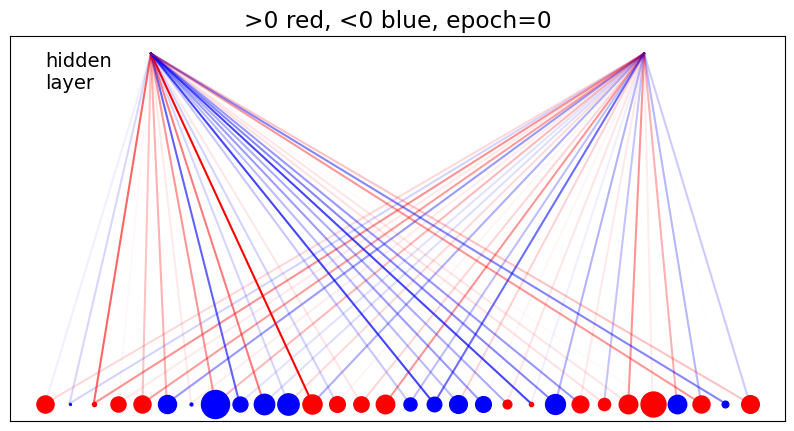

In [81]:
def create_coord(np,x0,f=1.0):
    x=[x0] * np
    #print(x)
    y=list(range(np))
    for i in range(np):
        y[i] = f*(y[i]/(np-1.) - 0.5)
    return (x,y)
(x1,y1)=create_coord(L,0)
(x2,y2)=create_coord(M,1,f=0.7)

def mycolor(val):
    if val>0: return 'red'
    elif val<0: return 'blue'
    else: return 'black'

def plotgraph_vert(epoch=0):
    A=2./w.max()
    for i in range(L):
        for j in range(M):
            ex, ey, col = (x1[i],x2[j]),(y1[i],y2[j]),mycolor(w[i][j])
            plt.plot(ex, ey, col, zorder=1, lw=A*abs(w[i][j]))
    # Scatter plot on top of lines
    
    A=300./(a.max()+b.max())
    
    for i in range(L):
        plt.scatter(x1[i], y1[i], s=A*abs(a[i]), zorder=2, c=mycolor(a[i]))

    for j in range(M):
        plt.scatter(x2[j], y2[j], s=A*abs(b[j]), zorder=2, c=mycolor(b[j]), marker="s")
    plt.figaspect(1)
    plt.title(f'>0 red, <0 blue, epoch={epoch}')
    plt.show()
    
def plotgraph(epoch=0):
    fig, ax = plt.subplots(1,1 , figsize=(10, 5))
    ax.tick_params(left=False,bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    
    A=1./max(w.max(),-w.min())
    for i in range(L):
        for j in range(M):
            ex, ey, col = (y1[i],y2[j]),(x1[i],x2[j]),mycolor(w[i][j])
            ax.plot(ex, ey, col, zorder=1, alpha=A*abs(w[i][j]))
    # Scatter plot on top of lines
    #A=300./(a.max()+b.max())
    A=500.
    for i in range(L):
        ax.scatter(y1[i],x1[i], s=A*abs(a[i]), zorder=2, c=mycolor(a[i]))
    for j in range(M):
        ax.scatter(y2[j], x2[j], s=min(300,A*abs(b[j])), zorder=2, c=mycolor(b[j]), marker="s")
    ax.set_title(f'>0 red, <0 blue, epoch={epoch}')
    ax.text(-0.5,0.9,"hidden\nlayer")
    plt.show()

plotgraph()
                  

**Activation function**

In [82]:
# eq(213) page 97, activation via sigmoid
# taking into account energy gap DE=2 for "spin" variables (-1,1)
def activate(v_in,wei,bias,DE,info=False):
    act = np.dot(v_in, wei) + bias
    n = np.shape(act)
    prob = 1. / (1. + exp(-DE*act))
    v_out = np.full(n, vmin, dtype=int) # a list on -1's or 0's
    v_out[np.random.random_sample(n) < prob] = 1 # activate the 1's with probability prob
    if info:
        print('input=', v_in)
        print("wei= ", wei)
        print('act=',act)
        print('prob=',prob)
        print('output=',v_out)
    return v_out

k = 0
activate(v[k],w,b,GAP,info=False)

array([1, 0])

**Optimizers**

In [83]:
betas = 0.9, 0.99
moment_1 = [0.0, 0.0, 0.0]
moment_2 = [0.0, 0.0, 0.0]
epsilon = 1*10**-8
count = 1                


def adam_optimizer(moment_1, moment_2, beta, w, a, b, count, epsilon,l_rate=0.001):     
    dparam=[w,a,b]
    for i in range(3):           
        moment_1[i]= beta[0]*moment_1[i] + (1-beta[0])*dparam[i]            
        moment_2[i]= beta[1]*moment_2[i]+(1-beta[1])*dparam[i]**2
        moment_1[i]= moment_1[i]/(1-beta[0]**count)
        moment_2[i] = moment_2[i]/(1-beta[1]**count)     
        dparam[i] = -l_rate*moment_1[i]/(np.sqrt(moment_2[i]) + epsilon ) 

    return(dparam[0],dparam[1],dparam[2], moment_1, moment_2)

ccc = adam_optimizer(moment_1, moment_2, betas, w, a, b, count, epsilon, l_rate=0.001)

print(ccc[0])


[[ 0.001      -0.001     ]
 [ 0.001       0.001     ]
 [-0.001      -0.001     ]
 [-0.001      -0.001     ]
 [-0.001      -0.001     ]
 [-0.001       0.001     ]
 [-0.001      -0.001     ]
 [-0.001      -0.001     ]
 [ 0.001       0.001     ]
 [-0.001       0.001     ]
 [ 0.001      -0.001     ]
 [-0.001       0.001     ]
 [ 0.001      -0.001     ]
 [-0.001      -0.001     ]
 [-0.00099997 -0.001     ]
 [ 0.001       0.001     ]
 [ 0.001       0.001     ]
 [ 0.001      -0.001     ]
 [ 0.001      -0.001     ]
 [ 0.001      -0.001     ]
 [ 0.001       0.001     ]
 [ 0.001       0.001     ]
 [ 0.001      -0.001     ]
 [-0.001       0.001     ]
 [-0.001      -0.001     ]
 [-0.001      -0.001     ]
 [ 0.001      -0.001     ]
 [-0.001       0.001     ]
 [ 0.001      -0.001     ]
 [-0.001       0.001     ]]


**Permutation of hidden and visible units**

In [84]:
v_combinations=[[1,0,0,0,0,0],[0,1,0,0,0,0],[0,0,1,0,0,0],[0,0,0,1,0,0],[0,0,0,0,1,0],[0,0,0,0,0,1]]
h_combinations=[[0],[1]]

#Generate all posible permutations with repetitions for vissible and hidden units
def permutation_txt(A,G,fname):
    P=[]
    for p in itertools.product(A, repeat=G):
        b=[]
        for i in range(G):
            b = b + p[i]
        P.append(b)
    np.savetxt(str(fname)+'.dat',np.asarray(P).astype(int),delimiter=" ",fmt="%d")
    return(np.asarray(P))

visible_layer = permutation_txt(v_combinations,5, "visible")
hidden_layer = permutation_txt(h_combinations,2, "hidden" )

**Energies and Probs**

In [85]:

#partition function
def energy(w,a,b,vp,hp):
    term_a=0
    term_b=0
    term_c=0
    total = 0
    PROB=[]
    for i in hp:
        for j in vp:
            a_0=np.matmul(j,w)
            
            term_a= np.matmul(a_0, i)
   
  
            term_b = np.matmul(a,j)

    
            term_c = np.matmul( b.reshape(1,2), i)
            
            prob = np.exp(term_a+term_b+term_c)
            PROB.append(prob)
            total = total + prob



    return(total, PROB)



def first_term_ll(vd, hp, w, a, b):
    M=len(vd)
    total=0
    total1=0
    for j in vd:
        for i in hp:
            a_0=np.matmul(j,w)
            
            term_a= np.matmul(a_0, i)
   
  
            term_b = np.matmul(a,j)

    
            term_c = np.matmul( b.reshape(1,2), i)

            prob = np.exp(term_a+term_b+term_c)
            total = total + prob
        total1 = total1 + np.log(total)
        total = 0
    
    return(total1/M)


**RBM backbone**

In [86]:
#Global parameters
def restricted_boltzman_machine(epoch, optimizer, cd_loops, backwards= False, printing=False, w=w, a=a, b=b):
    
    mini, m = 500, 0
    l_rate = 1.0
    likehood = []

    #Adam parameters
    betas = 0.9, 0.99
    moment_1 = [0.0, 0.0, 0.0]
    moment_2 = [0.0, 0.0, 0.0]
    epsilon = 1*10**-8
    count = 1
    #RMSprop parameters
    etha_1= 0.01
    etha_2 = 0.01
    mu = 0
    lam = 0


    
    for epoch_n in range(epoch):
        l_rate_m = l_rate / mini
        for k in range(N):
            #load zero arrays
            if m==0:
                v_data, v_model = np.zeros(L), np.zeros(L)
                h_data, h_model = np.zeros(M), np.zeros(M)
                vh_data,vh_model= np.zeros((L,M)),np.zeros((L,M))


            # generate h_data
            h = activate(v[k],w,b,GAP)
            v_data  += v[k]
            h_data  += h
            vh_data += np.outer(v[k].T,h)

            #number of CD loops 
            #for i in range(cd_loops):
                #generate v_model
            vf = backwards_function(h,w,a,GAP, backwards) #
                #generate h_model
            hf = activate(vf,w,b,GAP)
            #    h=hf
        


            #update units 
        
            v_model += vf
            h_model += hf
            vh_model+= np.outer(vf.T,hf)
        




            m+=1

            if m==mini:

                dw = l_rate_m*(vh_data - vh_model)
                da = l_rate_m*(v_data - v_model)
                db = l_rate_m*(h_data - h_model)

                if optimizer == "VanillaSGD":
                    # gradient of the likelihood: follow it along its positive direction
                    # with a "vanilla" SGD
                    # basic step of vanilla gradient descent, from eq.(211)
                    w = w + dw
                    a = a + da
                    b = b + db
                    m=0

                if optimizer == "adam":

                    dw, da, db, moment_1, moment_2 = adam_optimizer(moment_1, moment_2, betas, dw, da, db, count, epsilon )
                    count = count +1

                    w = w + dw
                    a = a + da
                    b = b + db







        # decrease the learning rate (here as a power law)
        np.random.shuffle(v)
        l_rate = l_rate / (0.01 * l_rate + 1)
    
        if epoch_n%10==9 and printing==True: 
            plotgraph(epoch_n+1)
            print('l_rate = ',l_rate)

        second_term=partition_function(w,a,b,visible_layer, hidden_layer)
        first_term=first_term_ll(v, hidden_layer, w, a, b)
        total_term = first_term - np.log(second_term[0])
        likehood.append(total_term)

    return(likehood, w, a, b, )

test_1 = restricted_boltzman_machine(100, "VanillaSGD", 1)

In [87]:
#Save weights 
np.savetxt("Dataw/weights_vanilla_optimizer.txt", w)
#Save visible unit bias
np.savetxt("Dataw/abias_vanilla_optimizer.txt", a)
#Save hidden unit bias
np.savetxt("Dataw/bbias_vanilla_optimizer.txt", b)


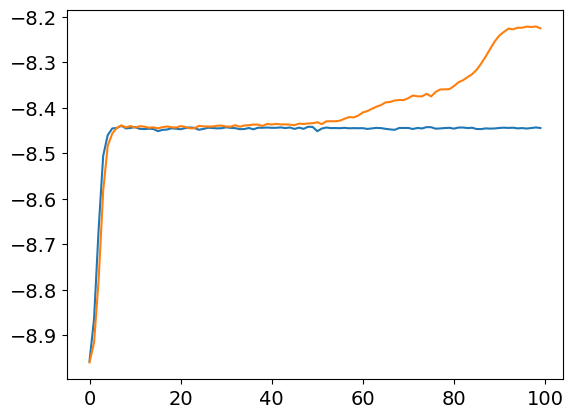

In [88]:

#np.savetxt("likehood_vanillaSGD.txt", np.asarray(likehood))
a=np.loadtxt("likehood_vanillaSGD.txt")

plt.plot(test_1[0])
plt.plot(a)
